# Introduction

This notebook finished the tasks from the [mini project document](LMM.pdf). 

There is a a dataset $\{ \mathbf{y}, \mathbf{X}, \mathbf{Z} \}$ with $n$ samples, 
where $\mathbf{y} \in \mathbb{R}^n$ is the vector of response variable, 
$\mathbf{X} \in \mathbb{R}^{n \times p}$ is the matrix of $p$ independent variables, 
and $\mathbf{Z} \in \mathbb{R}^{n \times c}$ is another matrix of $c$ variables. The notebook aimed to implement an Expectation-Maximization (EM) algorithm to find the best set of parameter $\Theta = \{\omega, \sigma^2_{\beta}, \sigma^2_{e}\}$ for a **linear mixed model** (LMM) 
$$
y = \mathbf{Z}\boldsymbol{\omega} + \mathbf{X}\boldsymbol{\beta} + \mathbf{e},
\qquad 
\boldsymbol{\beta}\sim \mathcal N(\mathbf{0},\,\sigma_\beta^2 \mathbf{I}_p), \quad
\mathbf{e}\sim \mathcal N(\mathbf{0},\,\sigma_e^2 \mathbf{I}_n).
$$ 


The implemented algorithm was applied to the [dataset](XYZ_MoM.txt).

Besides, it also demonstrated the implementation of the mean-field varaition inference (MFVI). A comparision between the MFVI and EM was made.

# 0. Load packages

In [31]:
from typing import Dict, Tuple, Optional
from em_lmm import _chol_solve, _safe_var
import numpy as np
import numpy.linalg as npl
import math
import matplotlib.pyplot as plt

# 1. Implementation of the EM algorithm

This step implemented the EM algorithm for a LMM. 

**Return at each iteration:**
- the marginal log-likelihood, 
- the current estimate of $\Theta=\{\boldsymbol{\omega},\sigma_\beta^2,\sigma_e^2\}$,
- and the posterior mean of $\boldsymbol{\beta}$.

## 1.1 Model setup and notations

- $y\in\mathbb R^n$: response vector  
- $\mathbf{Z}\in\mathbb R^{n\times c}$: fixed-effects design  
- $\mathbf{X}\in\mathbb R^{n\times p}$: random-effects design  
- $\boldsymbol{\omega}\in\mathbb R^c$: fixed effects
- $\boldsymbol{\beta}\in\mathbb R^p$: random effects
- $\mathbf{e}\in\mathbb R^n$: independent noise term 
- Unknown parameters: $\Theta=\{\boldsymbol{\omega},\sigma_\beta^2,\sigma_e^2\}$.  
- Latent variable: $\boldsymbol{\beta}\in\mathbb R^p$.

We treat $\boldsymbol{\beta}$ as **latent** because it is not observed; its prior is
$\boldsymbol{\beta}\sim\mathcal N(\mathbf{0},\sigma_\beta^2 \mathbf{I}_p)$.

## 1.2 Marginal likelihood (integrating out $\beta$)

**Conditionally on $\boldsymbol{\beta}$:**

Given fixed $\mathbf{Z}$, $\boldsymbol{\omega}$, and $\mathbf{X}$, when we conditioned on $\boldsymbol{\beta}$, $\mathbf{Z}\boldsymbol{\omega} + \mathbf{X}\boldsymbol{\beta}$ can be regarded as a constant. $y \mid \boldsymbol{\beta} = (\mathbf{Z}\boldsymbol{\omega} + \mathbf{X}\boldsymbol{\beta}) + \mathbf{e}$ is a _constant+gaussian noise_.

$$
y \mid \boldsymbol{\beta} \sim \mathcal N\!\big(\mathbf{Z}\boldsymbol{\omega} + \mathbf{X}\boldsymbol{\beta},\ \sigma_e^2 \mathbf{I}_n\big).
$$

**Integrating out $\boldsymbol{\beta}$ gives:**

- **Expectation:**
$$
\mathbb{E}[y] 
= \mathbb{E}_\beta\big[\mathbb{E}[y \mid \beta]\big] 
= \mathbb{E}_\beta[Z\omega + X\beta] 
= Z\omega + X \mathbb{E}[\beta] 
= Z\omega,
$$
because $$\beta \sim \mathcal N(0,\sigma_\beta^2 I_p)$$ has mean 0.


- **Covariance:**
$$
\operatorname{Cov}(y) 
= \mathbb{E}_\beta\!\big[\operatorname{Cov}(y \mid \beta)\big] 
+ \operatorname{Cov}_\beta\!\big(\mathbb{E}[y \mid \beta]\big).
$$

Here,
$$
\operatorname{Cov}(y \mid \beta) = \sigma_e^2 I_n, 
\qquad 
\mathbb{E}[y \mid \beta] = Z\omega + X\beta.
$$

Thus,
$$
\operatorname{Cov}(y) 
= \sigma_e^2 I_n + \operatorname{Cov}(X\beta)
= \sigma_e^2 I_n + X\,\operatorname{Cov}(\beta)\,X^\top
= \sigma_e^2 I_n + \sigma_\beta^2 XX^\top.
$$

$$
y \sim \mathcal N\!\big(\mathbf{Z}\boldsymbol{\omega},\ \boldsymbol{\Sigma}_y\big),
\qquad
\boldsymbol{\Sigma}_y = \sigma_e^2 \mathbf{I}_n + \sigma_\beta^2 \mathbf{X}\mathbf{X}^\top.
$$

**The marginal log-likelihood is:**
$$
\log p(y\mid\Theta)
= -\tfrac{n}{2}\log(2\pi)\ -\ \tfrac{1}{2}\log\lvert \boldsymbol{\Sigma}_y\rvert\ -\
\tfrac{1}{2}(y-\mathbf{Z}\boldsymbol{\omega})^\top \boldsymbol{\Sigma}_y^{-1}(y-\mathbf{Z}\boldsymbol{\omega}).
$$

This comes from the standard density of the multivariate Gaussian distribution:

$$
p(y) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}} 
\exp\!\left(-\tfrac{1}{2}(y-\mu)^\top \Sigma^{-1}(y-\mu)\right).
$$

Apply it here with $\mu = Z\omega$, $\Sigma = \Sigma_y$.

**To efficiently compute** the inverse and determinant of $\Sigma_y = \sigma_e^2 I_n + \sigma_\beta^2 X X^\top$ without directly forming the $n\times n$ matrix, we can apply the **Woodbury matrix identity**:

$$
(A + UCV)^{-1} 
= A^{-1} - A^{-1}U(C^{-1} + V A^{-1} U)^{-1}V A^{-1}.
$$

Let $A = \sigma_e^2 I_n,\; U = X,\; C = \sigma_\beta^2 I_p,\; V = X^\top.$
Then,  

$$
\Sigma_y^{-1} 
= \frac{1}{\sigma_e^2}\left[I_n 
- X\left(\frac{\sigma_e^2}{\sigma_\beta^2} I_p + X^\top X\right)^{-1} X^\top\right].
$$

Similarly, the log-determinant can be expressed as:

$$
\log|\Sigma_y| 
= n\log\sigma_e^2 
+ \log\left|I_p + \frac{\sigma_\beta^2}{\sigma_e^2} X^\top X\right|.
$$

These transformations reduce computations from $O(n^3)$ to $O(p^3)$,  
which is critical when $n \gg p$.

In [9]:
def marginal_loglik(y: np.ndarray,
                    Z: np.ndarray,
                    X: np.ndarray,
                    omega: np.ndarray,
                    sigma2_e: float,
                    sigma2_b: float) -> float:


    # Basic dimensions
    n, p = X.shape  # n: number of samples, p: number of random effects


    # Residual vector (y - Zω)
    v = y - Z @ omega          

    # Compute ratio σ²_b / σ²_e
    ratio = sigma2_b / sigma2_e

    # Construct the smaller p×p matrix A = I_p + (σ²_b/σ²_e) XᵀX using the Woodbury identity
    A = np.eye(p) + ratio * (X.T @ X)

    # Cholesky decomposition of A: A = LLᵀ
    L = npl.cholesky(A)

    # Compute log|Σ_y| efficiently
    logdet_Sy = n * math.log(sigma2_e) + 2.0 * float(np.sum(np.log(np.diag(L))))

    # Compute quadratic term (y - Zω)ᵀ Σ_y⁻¹ (y - Zω)
    rhs = X.T @ v              # Xᵀv
    w = _chol_solve(A, rhs)    # Solve A w = Xᵀv for w
    Sy_inv_v = (v - ratio * (X @ w)) / sigma2_e
    quad = float(v @ Sy_inv_v) 

    # Combine all parts of Gaussian log-density
    #    log p(y | Θ) = -½ [ n log(2π) + log|Σ_y| + vᵀ Σ_y⁻¹ v ]
    return -0.5 * (n * math.log(2.0 * math.pi) + logdet_Sy + quad)


## 1.3 E-step

In the E-step, we compute the expected value of the complete-data log-likelihood 
with respect to the posterior distribution of the latent variable $\beta$
under the current parameter estimates $\Theta^{(t)}$:

$$
Q(\Theta \mid \Theta^{(t)}) = \mathbb E_{\boldsymbol{\beta}\mid y,\Theta^{(t)}}
\big[\log p(y,\boldsymbol{\beta}\mid \Theta)\big].
$$

The _posterior of $\boldsymbol{\beta}$ under current parameters ($\Theta^{(t)}$) is:_
$$
\boldsymbol{\beta}\mid y,\Theta^{(t)} \sim \mathcal N\!\big(\mathbf{m}^{(t)},\ \mathbf{S}^{(t)}\big)
$$


**Notes:**
- The E-step **does not optimize** any parameters.
- It **computes the expectation** of the complete-data log-likelihood using the 
posterior of $\beta$ under current parameters $\Theta^{(t)}$.
- This expected value $Q(\Theta \mid \Theta^{(t)})$ 
becomes the objective function for the M-step.

### 1.3.1 Complete-data log-likelihood

The complete-data consists of the observed data $y$ and the latent variables $\beta$.  
By the model,
$$
p(y,\beta \mid \Theta) = p(y \mid \beta, \Theta)\, p(\beta \mid \Theta).
$$

- **Conditional likelihood:**
$$
y \mid \beta \sim \mathcal N(Z\omega + X\beta,\ \sigma_e^2 I_n).
$$

- **Prior:**
$$
\beta \sim \mathcal N(0,\ \sigma_\beta^2 I_p).
$$

Thus the complete-data log-likelihood (ignoring additive constants) is:
$$
\log p(y,\beta \mid \Theta)
= -\frac{n}{2}\log\sigma_e^2
  -\frac{1}{2\sigma_e^2}\|y - Z\omega - X\beta\|^2
  -\frac{p}{2}\log\sigma_\beta^2
  -\frac{1}{2\sigma_\beta^2}\|\beta\|^2.
$$


### 1.3.2 Posterior of $\beta$

Using Bayes’ theorem:

$$
p(\beta \mid y,\Theta) = p(y, \beta \mid \Theta)\, p(y \mid \Theta)
\propto 
p(y,\beta \mid \Theta) = p(y \mid \beta, \Theta)\,p(\beta \mid \Theta).
$$

Taking the logarithm again (up to a constant):

$$
\log p(\beta \mid y,\Theta)
= \log p(y \mid \beta, \Theta) + \log p(\beta \mid \Theta) + C
= -\frac{1}{2\sigma_e^2}\|y - Z\omega - X\beta\|^2
  -\frac{1}{2\sigma_\beta^2}\|\beta\|^2 + C.
$$


Expand the first term:

$$
\|y - Z\omega - X\beta\|^2
= (y - Z\omega)^\top(y - Z\omega)
  - 2\beta^\top X^\top(y - Z\omega)
  + \beta^\top X^\top X\beta.
$$

Substitute this into the log posterior:

$$
\log p(\beta \mid y,\Theta)
= -\frac{1}{2}\beta^\top
   \big(\sigma_e^{-2}X^\top X + \sigma_\beta^{-2}I_p\big)\beta
  + \beta^\top
   \big(\sigma_e^{-2}X^\top(y - Z\omega)\big)
  + \text{const}.
$$


Now, we identify the Gaussian form by "completing the square".

The above is a standard multivariate Gaussian log-density of the form:

$$
\log p(\beta \mid y,\Theta)
= -\frac{1}{2}(\beta - m)^\top S^{-1}(\beta - m) + \text{const}.
$$

Matching terms, we can identify:

$$
S^{-1} = \sigma_\beta^{-2}I_p + \sigma_e^{-2}X^\top X,
\qquad
S = \Big(\sigma_\beta^{-2}I_p + \sigma_e^{-2}X^\top X\Big)^{-1},
$$

$$
m = S\big(\sigma_e^{-2}X^\top(y - Z\omega)\big).
$$

Under the current parameter $\Theta^{(t)}$, the posterior distribution of 
$\beta$ is Gaussian:

$$
\beta \mid y,\Theta^{(t)} \sim 
\mathcal N\!\big(m^{(t)},\, S^{(t)}\big),
$$

where

$$
S^{(t)} = 
\Big(\sigma_\beta^{-2\,(t)} I_p 
      + \sigma_e^{-2\,(t)} X^\top X\Big)^{-1},
\qquad
m^{(t)} = 
S^{(t)}\!\Big(\sigma_e^{-2\,(t)} X^\top (y - Z\omega^{(t)})\Big).
$$


### 1.3.3 Compute the expectations

To take the expectation of $\log p(y,\beta \mid \Theta)$,
we only need to compute expectations involving $\beta$:

#### (a) Second moment of $\beta$
$$
\mathbb{E}\|\beta\|^2
= \|m^{(t)}\|^2 + \operatorname{tr}(S^{(t)}).
$$

This follows from the moment identity for a Gaussian:
$\mathbb{E}[xx^\top] = \mu\mu^\top + \Sigma.$

#### (b) Expected squared residual
$$
\mathbb{E}\|y - Z\omega - X\beta\|^2
= \|y - Z\omega - X m^{(t)}\|^2
  + \operatorname{tr}(X S^{(t)} X^\top).
$$

This comes from variance decomposition:
$$
\mathbb{E}\|a - X\beta\|^2 
= \|a - X\mathbb{E}[\beta]\|^2 
+ \operatorname{tr}(X \operatorname{Var}(\beta) X^\top).
$$

### 1.3.4 Substitute into $Q(\Theta \mid \Theta^{(t)})$

Substitute the two expectations into the complete-data log-likelihood:

$$
\boxed{
Q(\Theta \mid \Theta^{(t)}) 
= -\frac{n}{2}\log\sigma_e^2
  -\frac{1}{2\sigma_e^2}
     \Big(\|y - Z\omega - X m^{(t)}\|^2
          + \operatorname{tr}(X S^{(t)} X^\top)\Big)
  -\frac{p}{2}\log\sigma_\beta^2
  -\frac{1}{2\sigma_\beta^2}
     \Big(\|m^{(t)}\|^2
          + \operatorname{tr}(S^{(t)})\Big).
}
$$

## 1.4 M-step 


Given the E-step posterior $\beta \mid y,\Theta^{(t)} \sim \mathcal N(\mathbf{m}^{(t)}, \mathbf{S}^{(t)})$,
the $Q$-function (up to additive constants) is
$$
Q(\Theta\mid\Theta^{(t)}) 
= -\frac{n}{2}\log\sigma_e^{2}
  -\frac{1}{2\sigma_e^{2}}
     \Big(\,\|y-\mathbf{Z}\boldsymbol{\omega}-\mathbf{X}\mathbf{m}^{(t)}\|^2
          + \operatorname{tr}(\mathbf{X}\mathbf{S}^{(t)}\mathbf{X}^\top)\Big)
  -\frac{p}{2}\log\sigma_\beta^{2}
  -\frac{1}{2\sigma_\beta^{2}}
     \Big(\,\|\mathbf{m}^{(t)}\|^2 + \operatorname{tr}(\mathbf{S}^{(t)})\Big).
$$

We maximize $Q$ w.r.t. $\boldsymbol{\omega}$, $\sigma_e^2$, and $\sigma_\beta^2$.

### 1.4.1 Update for $\boldsymbol{\omega}$

**Problem:** minimize the quadratic term in $\boldsymbol{\omega}$:
$$
\min_{\boldsymbol{\omega}} \ \|y-\mathbf{Z}\boldsymbol{\omega}-\mathbf{X}\mathbf{m}^{(t)}\|^2.
$$

**Gradient:** 
$$
\frac{\partial}{\partial \boldsymbol{\omega}}
\|y-\mathbf{Z}\boldsymbol{\omega}-\mathbf{X}\mathbf{m}^{(t)}\|^2
= -2\mathbf{Z}^\top\!\big(y-\mathbf{Z}\boldsymbol{\omega}-\mathbf{X}\mathbf{m}^{(t)}\big).
$$

Set to zero:
$$
\mathbf{Z}^\top\mathbf{Z}\,\boldsymbol{\omega}^{(t+1)}
= \mathbf{Z}^\top\!\big(y - \mathbf{X}\mathbf{m}^{(t)}\big)
\quad\Longrightarrow\quad
\boxed{\;
\boldsymbol{\omega}^{(t+1)} 
= (\mathbf{Z}^\top\mathbf{Z})^{-1}\mathbf{Z}^\top\!\big(y-\mathbf{X}\mathbf{m}^{(t)}\big).
\;}
$$

**Principle:** ordinary least squares (OLS) of the “E-step–denoised response”
$y - \mathbf{X}\mathbf{m}^{(t)}$ onto the fixed-effects design $\mathbf{Z}$.


### 1.4.2 Update for $\sigma_e^2$

Keep only the $\sigma_e^2$-dependent part of $Q$:
$$
Q_e(\sigma_e^2)
= -\frac{n}{2}\log\sigma_e^{2}
  -\frac{1}{2\sigma_e^{2}}
     \underbrace{\Big(\|y-\mathbf{Z}\boldsymbol{\omega}^{(t+1)}-\mathbf{X}\mathbf{m}^{(t)}\|^2
     + \operatorname{tr}(\mathbf{X}\mathbf{S}^{(t)}\mathbf{X}^\top)\Big)}_{=: \ \mathcal{R}_e^{(t)} }.
$$

Differentiate and set to zero:
$$
\frac{\partial Q_e}{\partial \sigma_e^2}
= -\frac{n}{2}\frac{1}{\sigma_e^2}
  + \frac{1}{2}\frac{\mathcal{R}_e^{(t)}}{(\sigma_e^2)^2} = 0
\ \Longrightarrow\
\boxed{\;
\sigma_e^{2\,(t+1)} 
= \frac{\ \|y-\mathbf{Z}\boldsymbol{\omega}^{(t+1)}-\mathbf{X}\mathbf{m}^{(t)}\|^2
     + \operatorname{tr}(\mathbf{X}\mathbf{S}^{(t)}\mathbf{X}^\top)}{n}.
\;}
$$

**Principle:** MLE of a Gaussian variance equals the **average expected squared residual**.


### 1.4.3 Update for $\sigma_\beta^2$

Keep only the $\sigma_\beta^2$-dependent part:
$$
Q_\beta(\sigma_\beta^2)
= -\frac{p}{2}\log\sigma_\beta^{2}
  -\frac{1}{2\sigma_\beta^{2}}
     \underbrace{\Big(\|\mathbf{m}^{(t)}\|^2 + \operatorname{tr}(\mathbf{S}^{(t)})\Big)}_{=: \ \mathcal{R}_\beta^{(t)}}.
$$

Differentiate and set to zero:
$$
\frac{\partial Q_\beta}{\partial \sigma_\beta^2}
= -\frac{p}{2}\frac{1}{\sigma_\beta^2}
  + \frac{1}{2}\frac{\mathcal{R}_\beta^{(t)}}{(\sigma_\beta^2)^2}=0
\ \Longrightarrow\
\boxed{\;
\sigma_\beta^{2\,(t+1)} 
= \frac{\ \|\mathbf{m}^{(t)}\|^2 + \operatorname{tr}(\mathbf{S}^{(t)})\ }{p}.
\;}
$$

**Principle:** the prior variance matches the **average posterior second moment** of $\beta$.

In [72]:
def em_lmm(y: np.ndarray,
           X: np.ndarray,
           Z: np.ndarray,
           max_iter: int = 200,
           tol: float = 1e-6,
           ridge: float = 1e-8
           ) -> Tuple[Dict[str, float], Dict[str, np.ndarray], Dict[str, list]]:

    # Initialization
    n, p = X.shape       # n: number of observations, p: number of random effects
    _, c = Z.shape       # c: number of fixed effects

    # Initialize ω by ordinary least squares (ignoring random effects)
    omega = npl.lstsq(Z, y, rcond=None)[0]

    # Initialize σ²_e using residual variance from OLS
    sigma2_e = _safe_var(y - Z @ omega)

    # Initialize σ²_b as 10% of σ²_e (small but nonzero random-effect variance)
    sigma2_b = float(max(0.1 * sigma2_e, 1e-6))

    # Record iteration history for monitoring convergence
    history = {"ll": [], "sigma2_e": [], "sigma2_b": [], "omega_norm": []}

    # trace computation
    def _trace_terms(A: np.ndarray) -> Tuple[float, float]:
        I_p = np.eye(p)
        S = _chol_solve(A, I_p)          # S = A^{-1}
        tr_S = float(np.trace(S))       # tr(S)
        tr_XSXt = float(np.trace(X @ S @ X.T)) # tr(X S Xᵀ)
        return S, tr_S, tr_XSXt

    # EM iterations
    prev_ll = -np.inf
    for it in range(max_iter):

        # E-step: compute posterior mean & covariance of β

        # Residuals after accounting for fixed effects only
        r = y - Z @ omega

        # Posterior precision of β: A = σₑ⁻² XᵀX + σ_b⁻² I + λI
        A = (X.T @ X) / max(sigma2_e, 1e-12) + np.eye(p) / max(sigma2_b, 1e-12) + ridge * np.eye(p)

        # Posterior mean of β: m = A⁻¹ σₑ⁻² Xᵀ(y - Zω)
        m = _chol_solve(A, (X.T @ r) / max(sigma2_e, 1e-12))

        # Posterior covariance traces:
        #   tr(S) = trace(A⁻¹)
        #   tr(X S Xᵀ) = trace(X A⁻¹ Xᵀ)
        S, tr_S, tr_XSXt = _trace_terms(A)



        # M-step: update ω, σ²_e, σ²_b

        # Update fixed effects ω by least squares: ω = (ZᵀZ + λI)⁻¹ Zᵀ(y - X m)
        ZZ = Z.T @ Z + ridge * np.eye(c)
        Zy = Z.T @ (y - X @ m)
        omega = npl.solve(ZZ, Zy)

        # Update residuals after both effects are accounted for
        resid = y - Z @ omega - X @ m

        # Update noise variance: σ²_e = (‖resid‖² + tr(X S Xᵀ)) / n
        sigma2_e = float(max((resid @ resid + tr_XSXt) / n, 1e-12))

        # Update random-effect variance: σ²_b = (‖m‖² + tr(S)) / p
        sigma2_b = float(max((m @ m + tr_S) / p, 1e-12))


        # Compute marginal log-likelihood (for monitoring)
        ll = marginal_loglik(y, Z, X, omega, sigma2_e, sigma2_b)
        history["ll"].append(ll)
        history["sigma2_e"].append(sigma2_e)
        history["sigma2_b"].append(sigma2_b)
        history["omega_norm"].append(float(npl.norm(omega)))


        print(f"[EM] iter {it:3d} log p(y)={ll:.6f}")
        # Check for convergence based on log-likelihood
        if it > 0:
            rel_improve = abs(history["ll"][-1] - history["ll"][-2]) / max(1.0, abs(history["ll"][-2]))
            if rel_improve < tol:
                break

        


    # Return estimates after convergence
    theta_hat = {"omega": omega, "sigma2_e": sigma2_e, "sigma2_b": sigma2_b}
    beta = {"mean": m, "cov": S}
    return theta_hat, beta, history


## 1.5 Demo


Here is a demonstration of the generated EM algorithm for LMM on a small set of simulated data.

### 1.5.1 Simulate data

In [42]:
np.random.seed(42)

n, p, c = 200, 5, 2   # n: samples, p: random effects, c: fixed effects

# True parameters
sigma2_e_true = 1.0
sigma2_b_true = 2.0
omega_true = np.array([1.5, -0.5])   # fixed-effect coefficients

# Design matrices
Z = np.random.randn(n, c)             # Fixed-effect design
X = np.random.randn(n, p)             # Random-effect design

# Random effect β ~ N(0, σ²_b I)
beta_true = np.random.randn(p) * np.sqrt(sigma2_b_true)

# Noise ε ~ N(0, σ²_e I)
eps = np.random.randn(n) * np.sqrt(sigma2_e_true)

# Generate response
y = Z @ omega_true + X @ beta_true + eps

print("Simulated data:")
print(f"n={n}, p={p}, c={c}")
print(f"True omega: {omega_true}")
print(f"True σ²_b={sigma2_b_true}, σ²_e={sigma2_e_true}\n")


Simulated data:
n=200, p=5, c=2
True omega: [ 1.5 -0.5]
True σ²_b=2.0, σ²_e=1.0



### 1.5.2 Run EM algorithm and get the results

Run EM algorithm.

In [74]:
theta_hat, beta, history = em_lmm(y, X, Z, max_iter=200, tol=1e-6, ridge=1e-8)

[EM] iter   0 log p(y)=-306.343955
[EM] iter   1 log p(y)=-304.893733
[EM] iter   2 log p(y)=-304.892404
[EM] iter   3 log p(y)=-304.892403


Get the estimate of $\Theta$.

In [65]:
print("EM finished after", len(history["ll"]), "iterations.\n")
print("Estimated parameters:")
print(f"omega_hat   = {theta_hat['omega']}")
print(f"sigma2_b̂   = {theta_hat['sigma2_b']:.4f} (true={sigma2_b_true})")
print(f"sigma2_ê   = {theta_hat['sigma2_e']:.4f} (true={sigma2_e_true})")

EM finished after 4 iterations.

Estimated parameters:
omega_hat   = [ 1.37157345 -0.4381529 ]
sigma2_b̂   = 1.7281 (true=2.0)
sigma2_ê   = 1.0693 (true=1.0)


Get the marginal log likelihood.

In [45]:
print("Marginal log likelihood at each iteration:")
print(history["ll"])

Marginal log likelihood at each iteration:
[-306.34395457281573, -304.893732906587, -304.8924042789314, -304.8924031580785]


Plot the marginal log likelihood.

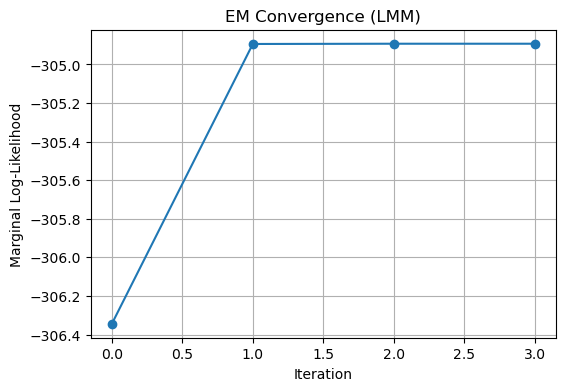

In [46]:
plt.figure(figsize=(6,4))
plt.plot(history["ll"], marker='o')
plt.xlabel("Iteration")
plt.ylabel("Marginal Log-Likelihood")
plt.title("EM Convergence (LMM)")
plt.grid(True)
plt.show()

Check the posterior mean of $\beta$.

In [75]:
print("\nPosterior mean of β (first few entries):")
print(beta["mean"][:min(5,p)])

print("\nTrue β (first few entries):")
print(beta_true[:min(5,p)])


Posterior mean of β (first few entries):
[-1.44955654  0.77050568  1.71912188  0.98894637  1.40868547]

True β (first few entries):
[-1.48055571  0.7589416   1.6768389   1.01675352  1.40862415]


# 2. Apply the implementation to dataset

In this step, I applied the implemented algorithm to the dataset provided ```XYZ_MOM.txt```. The estimated parameters will be returned.

## 2.1 Run EM algorithm

Load ```XYZ_MOM.txt``` dataset.

As described, The columns labeled with Z.1∼Z.30 correspond to the matrix Z and the columns labeled with X.1∼X.6000 correspond to the matrix X. 

In [51]:
data_path = "XYZ_MOM.txt"
data = np.loadtxt(data_path,skiprows=1)
y_data = data[:, 0]
Z_data = data[:, 1:31]
X_data = data[:, 31:]

In [52]:
y_data.shape, Z_data.shape, X_data.shape

((1000,), (1000, 30), (1000, 6000))

Here we checked the dimensions of the data: $\mathbf{y}\in\mathbb{R}^{1000}$, $\mathbf{Z}\in\mathbb{R}^{1000 \times 30}$, $\mathbf{X}\in\mathbb{R}^{1000 \times 6000}$.

Run EM algorithm with the function ```em_lmm()```.

In [84]:
theta_hat_em, beta_em, history_em = em_lmm(y_data, X_data, Z_data, max_iter=200, tol=1e-6, ridge=1e-8)

[EM] iter   0 log p(y)=-1360.629556
[EM] iter   1 log p(y)=-1360.556073
[EM] iter   2 log p(y)=-1360.552741
[EM] iter   3 log p(y)=-1360.551905


## 2.2 Retrieve the results

In [ ]:
print("EM finished after", len(history_em["ll"]), "iterations.\n")
print("Estimated parameters:")
print(f"omega_hat   = {theta_hat_em['omega']}")
print(f"sigma2_b̂   = {theta_hat_em['sigma2_b']:.4f}")
print(f"sigma2_ê   = {theta_hat_em['sigma2_e']:.4f} ")

print("Marginal log likelihood at each iteration:")
print(history_em["ll"])

EM finished after 4 iterations.

Estimated parameters:
omega_hat   = [ 0.00138773 -0.01182302  0.00743065 -0.00301858 -0.00447637 -0.03567541
 -0.02950013  0.0093439  -0.04802922 -0.07086734 -0.02019504 -0.02365049
 -0.04484756 -0.01916863 -0.00049561  0.04457313  0.00169456  0.00191603
 -0.03549423 -0.00468694 -0.00223575 -0.04084355 -0.01059439  0.01210981
  0.00670014  0.01483808  0.01397361 -0.00763556 -0.0047278   0.04826396]
sigma2_b̂   = 0.0888
sigma2_ê   = 0.7991 
Marginal log likelihood at each iteration:
[-1360.629556257861, -1360.5560729799913, -1360.552741250189, -1360.5519047677128]


# 3. Implementation of MFVI

## 3.1 Model setup and notations

The model setup is and notations is the same as EM algorithm. 


We consider the linear mixed model (LMM):
$$
y = Z\omega + X\beta + \varepsilon,
$$
where  
$$
\varepsilon \sim \mathcal{N}(0, \sigma_e^2 I_n), 
\quad \beta \sim \mathcal{N}(0, \sigma_\beta^2 I_p).
$$
The parameters to estimate are
$$
\Theta = \{\omega, \sigma_e^2, \sigma_\beta^2\}.
$$

The complete-data likelihood is
$$
p(y,\beta|\Theta)
= p(y|\beta,\Theta) \, p(\beta|\Theta)
= \mathcal{N}(y|Z\omega + X\beta, \sigma_e^2 I_n) \,
  \mathcal{N}(\beta|0, \sigma_\beta^2 I_p)
$$
as we calculated in the E step of EM algorithm.

## 3.2 Variational Approximation

The true posterior
$$
p(\beta|y; \Theta)
\propto p(y,\beta|\Theta)
$$
is often intractable when $p$ is large.

We approximate it using a **mean-field variational family**:
$$
q(\beta) = \prod_{j=1}^p q_j(\beta_j), \qquad
q_j(\beta_j) = \mathcal{N}(m_j, s_j),
$$
where $m = (m_1,\ldots,m_p)$ and $s = (s_1,\ldots,s_p)$ are variational parameters.


## 3.3 Variational Objective (ELBO)

The true posterior is:

$$
p(\beta \mid y) = \frac{p(y, \beta)}{p(y)}.
$$

Then take the log of the posterior:

$$
\log p(y) = \mathcal{L}(q, \Theta) + KL(q(\beta) || p(\beta \mid y)),
$$

where the **Evidence Lower Bound (ELBO)** is:

$$
\boxed{
\begin{aligned}
\mathcal{L}(q, \Theta)
&= \mathbb{E}_q[\log p(y, \beta)]
 - \mathbb{E}_q[\log q(\beta)] \\
&= \mathbb{E}_q[\log p(y \mid \beta, \Theta)] + \mathbb{E}_q[\log p(\beta \mid \Theta)]
 - \mathbb{E}_q[\log q(\beta)]
\end{aligned}}
,
$$

and the KL divergence is:

$$
KL(q(\beta) || p(\beta \mid y)) = \mathbb{E}_{q}[\log \frac{q(\beta)}{p(\beta \mid y)}].
$$

We want to let $q(\beta)$ close to the true posterior $p(\beta \mid y)$ as much as possible, so we'll need to find the $q$ that minimize the KL divergence:

$$
q^*(\beta) = \arg\min_q KL(q(\beta) || p(\beta \mid y)).
$$

Given that the KL divergence is always $\ge 0$, 

$$
\boxed{
\mathcal{L}(q,\Theta) \le \log p(y|\Theta),
\quad
\text{and equality holds iff } q(\beta)=p(\beta|y,\Theta).
}
$$.

Minimizing KL equals to maximizing ELBO:

$$
q^*(\beta) = \arg \max_q \mathcal{L}(q).
$$

Expanding each term as follows:

### 3.3.1 Likelihood term

$$
\begin{aligned}
\mathbb{E}_q[\log p(y|\beta, \Theta)]
&= -\frac{n}{2}\log(2\pi\sigma_e^2)
   - \frac{1}{2\sigma_e^2}
     \mathbb{E}_q[\|y - Z\omega - X\beta\|^2] \\
&= -\frac{n}{2}\log(2\pi\sigma_e^2)
   - \frac{1}{2\sigma_e^2}
     \Big(\|y - Z\omega - X m\|^2 + \operatorname{tr}(X\,\mathrm{diag}(s)\,X^\top)\Big).
\end{aligned}
$$

### 3.3.2 Prior term
$$
\begin{aligned}
\mathbb{E}_q[\log p(\beta|\Theta)]
&= -\frac{p}{2}\log(2\pi\sigma_\beta^2)
   - \frac{1}{2\sigma_\beta^2}
     \mathbb{E}_q[\|\beta\|^2] \\
&= -\frac{p}{2}\log(2\pi\sigma_\beta^2)
   - \frac{1}{2\sigma_\beta^2}(\|m\|^2 + \sum_{j=1}^p s_j).
\end{aligned}
$$


### 3.3.3 Entropy term
$$
\mathbb{E}_q[-\log q(\beta)]
= \frac{1}{2}\sum_{j=1}^p \log(2\pi e\, s_j).
$$

### 3.3.4 Full ELBO
$$
\boxed{
\begin{aligned}
\mathcal{L}(q,\Theta)
&= -\frac{n}{2}\log(2\pi\sigma_e^2)
   - \frac{1}{2\sigma_e^2}
     \Big(\|y - Z\omega - X m\|^2 + \operatorname{tr}(X\,\mathrm{diag}(s)\,X^\top)\Big) \\
&\quad -\frac{p}{2}\log(2\pi\sigma_\beta^2)
   - \frac{1}{2\sigma_\beta^2}(\|m\|^2 + \sum_j s_j)
   + \frac{1}{2}\sum_j \log(2\pi e\, s_j).
\end{aligned}
}
$$

In [32]:
def _elbo_lmm(y: np.ndarray,
              Z: np.ndarray,
              X: np.ndarray,
              omega: np.ndarray,
              m: np.ndarray,
              s2_diag: np.ndarray,
              sigma2_e: float,
              sigma2_b: float) -> float:
    
    n, p = X.shape
    # E[||y - Zω - Xβ||^2] = ||y - Zω - X m||^2 + Tr(X S X^T), S=diag(s2_diag)
    r_mean = y - Z @ omega - X @ m
    term1 = float(r_mean @ r_mean)
    x_norm2 = (X**2).sum(axis=0)
    tr_xsx = float((s2_diag * x_norm2).sum())

    Eq_log_like = -0.5 * n * np.log(2.0 * np.pi * sigma2_e) - 0.5 * (term1 + tr_xsx) / sigma2_e

    # Prior: β ~ N(0, σ_b^2 I)
    Eb2 = float((m**2 + s2_diag).sum())
    Eq_log_prior = -0.5 * p * np.log(2.0 * np.pi * sigma2_b) - 0.5 * Eb2 / sigma2_b

    # Entropy of factorized Gaussian q
    entropy = 0.5 * np.log(2.0 * np.pi * np.e * s2_diag).sum()

    return float(Eq_log_like + Eq_log_prior + entropy)

## 3.4 E-step

We assume the mean-field family
$$
q(\beta)=\prod_{k=1}^p q_k(\beta_k),\qquad 
q_k(\beta_k)=\mathcal N(m_k, s_k).
$$
Fix $\Theta=\{\omega,\sigma_e^2,\sigma_\beta^2\}$.  
The optimal factor $q_j(\beta_j)$ satisfies the standard mean-field identity
$$
\log q_j^*(\beta_j)\;=\;\mathbb E_{q(\beta_{-j})}\!\left[\log p(y,\beta\mid\Theta)\right] + \text{const},
$$
where $\beta_{-j}$ denotes all coordinates except $j$.

### 3.4.1 Joint log-density up to a constant
Under the LMM,
$$
\log p(y,\beta\mid\Theta)
= -\frac{1}{2\sigma_e^2}\,\big\|y - Z\omega - X\beta\big\|^2
  -\frac{1}{2\sigma_\beta^2}\,\|\beta\|^2 + \text{const}.
$$

Let $x_k$ be the $k$-th column of $X$. Then
$$
\|y - Z\omega - X\beta\|^2
= \Big\|\,y - Z\omega - \sum_{k=1}^p x_k\beta_k\,\Big\|^2.
$$

Split out the $j$-th coordinate by defining the **partial residual**
$$
r_{-j}\;\coloneqq\; y - Z\omega - \sum_{k\neq j} x_k\,\beta_k.
$$
Then
$$
\|y - Z\omega - X\beta\|^2 \;=\; \|\,r_{-j} - x_j\beta_j\,\|^2
= r_{-j}^\top r_{-j} - 2\beta_j x_j^\top r_{-j} + \beta_j^2 \|x_j\|^2.
$$

### 3.4.2 Take expectation over $q(\beta_{-j})$
Since $r_{-j}$ depends only on $\beta_{-j}$, we replace it by its expectation under $q(\beta_{-j})$:
$$
\mathbb E_{-j}[r_{-j}] \;=\; y - Z\omega - \sum_{k\neq j} x_k\, m_k
\;\eqqcolon\; \bar r_{-j}.
$$
The term $r_{-j}^\top r_{-j}$ does not involve $\beta_j$ when taking expectation and thus folds into a constant (w.r.t.\ $\beta_j$). Therefore, up to an additive constant,
$$
\mathbb E_{-j}\!\left[\log p(y,\beta\mid\Theta)\right]
= -\frac{1}{2\sigma_e^2}\Big(\beta_j^2\|x_j\|^2 - 2\beta_j x_j^\top \bar r_{-j}\Big)
  -\frac{1}{2\sigma_\beta^2}\,\beta_j^2 + \text{const}.
$$

### 3.4.3 Read off the Gaussian form
Collect the quadratic and linear terms in $\beta_j$:
$$
\log q_j^*(\beta_j) \;=\;
-\frac{1}{2}\Big(\underbrace{\frac{\|x_j\|^2}{\sigma_e^2}+\frac{1}{\sigma_\beta^2}}_{\text{precision } \tau_j}\Big)\beta_j^2
\;+\;
\Big(\underbrace{\frac{x_j^\top \bar r_{-j}}{\sigma_e^2}}_{\text{linear coef.}}\Big)\beta_j
\;+\; \text{const}.
$$
Hence $q_j^*(\beta_j)$ is Gaussian with precision $\tau_j$ and mean $\mu_j$:
$$
s_j \;=\; \tau_j^{-1}
= \left(\frac{\|x_j\|^2}{\sigma_e^2}+\frac{1}{\sigma_\beta^2}\right)^{-1},
\qquad
m_j \;=\; s_j\;\frac{x_j^\top \bar r_{-j}}{\sigma_e^2}.
$$

Using $\bar r_{-j}= y - Z\omega - \sum_{k\neq j} x_k m_k$, the **coordinate ascent updates** become
$$
\boxed{
\begin{aligned}
s_j^{\text{new}} &= \left(\frac{\|x_j\|^2}{\sigma_e^2}+\frac{1}{\sigma_\beta^2}\right)^{-1},
m_j^{\text{new}} &= s_j^{\text{new}}\;\frac{x_j^\top\!\left(y - Z\omega - \sum_{k\neq j} x_k m_k\right)}{\sigma_e^2}.
\end{aligned}
}
$$

### 3.4.5 Residual trick (implementation)
Define the running residual at the current $m$:
$$
r \;=\; y - Z\omega - X m.
$$
Then the per-coordinate update can be done in $O(n)$ time by:
$$
r \leftarrow r + x_j\,m_j,\qquad
m_j \leftarrow s_j\,\frac{x_j^\top r}{\sigma_e^2},\qquad
r \leftarrow r - x_j\,m_j.
$$
This avoids recomputing $\sum_{k\neq j} x_k m_k$ from scratch and yields an overall $O(np)$ pass per sweep.

## 3.5 M-step

Maximize ELBO w.r.t. $\Theta = (\omega, \sigma_e^2, \sigma_\beta^2)$, holding $q(\beta)$ fixed:

$$
\boxed{
\begin{aligned}
\omega^{\text{new}}
&= (Z^\top Z)^{-1} Z^\top (y - X m), \\
\sigma_e^{2\,\text{new}}
&= \frac{1}{n}\Big(\|y - Z\omega - X m\|^2 + \operatorname{tr}(X\,\mathrm{diag}(s)\,X^\top)\Big), \\
\sigma_\beta^{2\,\text{new}}
&= \frac{1}{p}\Big(\|m\|^2 + \sum_j s_j\Big).
\end{aligned}
}
$$

In the **M-step**, we fix the current variational distribution $q(\beta)$
and maximize the ELBO with respect to the model parameters $\Theta$.

Recall that the ELBO can be written (up to constants) as:

$$
\mathcal{L}(q, \Theta)
= \mathbb{E}_q[\log p(y|\beta,\Theta)]
+ \mathbb{E}_q[\log p(\beta|\Theta)]
- \mathbb{E}_q[\log q(\beta)].
$$

Since the last term does not depend on $\Theta$,
we only need to maximize the first two expectations.

### 3.5.1 Expected complete log-likelihood

We already have:

$$
\mathbb{E}_q[\log p(y|\beta,\Theta)]
= -\frac{n}{2}\log(2\pi\sigma_e^2)
  -\frac{1}{2\sigma_e^2}\,
  \mathbb{E}_q\!\left[\|y - Z\omega - X\beta\|^2\right].
$$

Now expand the quadratic expectation term:

$$
\begin{aligned}
\mathbb{E}_q[\|y - Z\omega - X\beta\|^2]
&= \|y - Z\omega - X\mathbb{E}_q[\beta]\|^2
  + \mathrm{tr}\!\left(X\,\mathrm{Cov}_q[\beta]\,X^\top\right) \\
&= \|y - Z\omega - X m\|^2 + \mathrm{tr}\!\left(X\,\mathrm{diag}(s)\,X^\top\right),
\end{aligned}
$$
where $m = (m_1,\dots,m_p)$ and $s = (s_1,\dots,s_p)$ are the mean and variances of $q(\beta)$.


### 3.5.2 Expected prior term

Similarly,
$$
\mathbb{E}_q[\log p(\beta|\Theta)]
= -\frac{p}{2}\log(2\pi\sigma_\beta^2)
  -\frac{1}{2\sigma_\beta^2}\,\mathbb{E}_q[\|\beta\|^2].
$$
Since
$$
\mathbb{E}_q[\|\beta\|^2] = \|m\|^2 + \sum_j s_j,
$$
we have
$$
\mathbb{E}_q[\log p(\beta|\Theta)]
= -\frac{p}{2}\log(2\pi\sigma_\beta^2)
  -\frac{1}{2\sigma_\beta^2}(\|m\|^2 + \sum_j s_j).
$$

### 3.5.3 Optimize with respect to each parameter

#### 3.5.3.1 Update for $ \omega $

Only the first expectation term depends on $\omega$:

$$
\mathcal{L}_\omega = -\frac{1}{2\sigma_e^2}\|y - Z\omega - X m\|^2.
$$

Maximizing this (or equivalently minimizing the norm term) gives:

$$
\frac{\partial \mathcal{L}_\omega}{\partial \omega} = 0
\quad \Rightarrow \quad
Z^\top (y - Z\omega - X m) = 0
\quad \Rightarrow \quad
\boxed{
\omega^{\text{new}} = (Z^\top Z)^{-1} Z^\top (y - X m).
}
$$

#### 3.5.3.2 Update for $ \sigma_e^2 $

The ELBO contains:
$$
\mathcal{L}_{\sigma_e^2}
= -\frac{n}{2}\log\sigma_e^2
  -\frac{1}{2\sigma_e^2}\left(
  \|y - Z\omega - X m\|^2 + \mathrm{tr}(X\,\mathrm{diag}(s)\,X^\top)
  \right).
$$
Take derivative and set to zero:

$$
\frac{\partial \mathcal{L}}{\partial \sigma_e^2} = 0
\quad\Rightarrow\quad
\sigma_e^{2\,\text{new}} =
\frac{1}{n}\left(
\|y - Z\omega - X m\|^2 + \mathrm{tr}(X\,\mathrm{diag}(s)\,X^\top)
\right).
$$

#### 3.5.3.3 Update for $ \sigma_\beta^2 $

Similarly,
$$
\mathcal{L}_{\sigma_\beta^2}
= -\frac{p}{2}\log\sigma_\beta^2
  -\frac{1}{2\sigma_\beta^2}\left(\|m\|^2 + \sum_j s_j\right).
$$
Derivative = 0 gives:

$$
\sigma_\beta^{2\,\text{new}}
= \frac{1}{p}\left(\|m\|^2 + \sum_j s_j\right).
$$


#### 3.5.3.4 Summary of parameters update

$$
\boxed{
\begin{aligned}
\omega^{\text{new}} &= (Z^\top Z)^{-1} Z^\top (y - X m),\\
\sigma_e^{2\,\text{new}} &= \frac{1}{n}
\left(\|y - Z\omega - X m\|^2 + \mathrm{tr}(X\,\mathrm{diag}(s)\,X^\top)\right),\\
\sigma_\beta^{2\,\text{new}} &= \frac{1}{p}
\left(\|m\|^2 + \sum_j s_j\right).
\end{aligned}
}
$$

These are the **closed-form coordinate updates** for the M-step in the mean-field variational inference algorithm.

In [ ]:
def mfvi_lmm(y: np.ndarray,
             X: np.ndarray,
             Z: np.ndarray,
             max_iter: int = 1000,
             tol: float = 1e-6,
             ridge: float = 0.0,
             alpha_init: Tuple[float, float, np.ndarray] = None) -> Tuple[Dict[str, float], Dict[str, np.ndarray], Dict[str, list]]:
    
    """
    LMM: y = Zω + Xβ + ε,  β ~ N(0, σ_b^2 I), ε ~ N(0, σ_e^2 I)
    Mean-field VI: q(β)=∏_j N(m_j, s_j^2)
    M-step updates:
      ω ← argmin ||(y - X m) - Zω||^2
      σ_e^2 ← (||y - Zω - X m||^2 + Tr(X S X^T))/n
      σ_b^2 ← (||m||^2 + Tr(S))/p
    """
    
    # Basic dimensions
    n, p = X.shape
    _, c = Z.shape

    # initialization
    if alpha_init is None:
        # OLS for ω ignoring random effect
        omega = npl.lstsq(Z, y, rcond=None)[0]
        resid_ols = y - Z @ omega
        sigma2_e = float(max(np.var(resid_ols), 1e-12))
        sigma2_b = float(max(0.1 * sigma2_e, 1e-6))
    else:
        sigma2_e, sigma2_b, omega = alpha_init

    # q(β): start with zeros mean
    m = np.zeros(p)
    x_norm2 = (X**2).sum(axis=0)

    # Variances per coordinate
    s2 = 1.0 / ( (1.0 / max(sigma2_b,1e-12)) + x_norm2 / max(sigma2_e,1e-12) + ridge )

    history = {"elbo": [], "ll": [], "sigma2_e": [], "sigma2_b": [], "omega_norm": []}

    for it in range(max_iter):
        m_old, omega_old = m.copy(), omega.copy()
        sigma2_e_old, sigma2_b_old = sigma2_e, sigma2_b

        # ----- E-step: coordinate ascent over j for q(β_j) -----
        # s2_j = 1 / (σ_b^{-2} + ||x_j||^2 / σ_e^2 + ridge)
        s2 = 1.0 / ( (1.0 / max(sigma2_b,1e-12)) + x_norm2 / max(sigma2_e,1e-12) + ridge )

        # residual trick including fixed effects
        Xm = X @ m
        r0 = y - Z @ omega  # remove fixed effect first
        for j in range(p):
            # r_j = (y - Zω) - X m + x_j m_j
            r_j = r0 - Xm + X[:, j] * m[j]

            # m_j = s2_j * (x_j^T r_j) / σ_e^2
            m_j_new = s2[j] * (X[:, j].dot(r_j)) / max(sigma2_e, 1e-12)

            # keep up-to-date
            Xm += X[:, j] * (m_j_new - m[j])
            m[j] = m_j_new

        S_trace = float(s2.sum())
        Tr_XSXt = float((s2 * x_norm2).sum())

        # M-step: update ω, σ_e^2, σ_b^2
        # ω = (Z^T Z)^{-1} Z^T (y - X m)
        ZZ = Z.T @ Z + ridge * np.eye(c)
        Zy = Z.T @ (y - X @ m)
        omega = npl.solve(ZZ, Zy)

        resid = y - Z @ omega - X @ m
        sigma2_e = float(max((resid @ resid + Tr_XSXt) / n, 1e-12))
        sigma2_b = float(max(((m @ m) + S_trace) / p, 1e-12))

        # diagnostics
        elbo = _elbo_lmm(y, Z, X, omega, m, s2, sigma2_e, sigma2_b)
        ll = marginal_loglik(y, Z, X, omega, sigma2_e, sigma2_b)
        history["elbo"].append(elbo)
        history["ll"].append(ll)
        history["sigma2_e"].append(sigma2_e)
        history["sigma2_b"].append(sigma2_b)
        history["omega_norm"].append(float(npl.norm(omega)))


        if it % 25 == 0 or it == max_iter - 1:
            print(f"[MFVI] iter {it:3d}  ELBO={elbo:.6f}  log p(y)={ll:.6f}  gap={ll-elbo:.6f}")
    
        # convergence
        if it > 0:
            rel_improve = (history["elbo"][-1] - history["elbo"][-2]) / max(1.0, abs(history["elbo"][-2]))
            if rel_improve < tol:
                break

    theta_hat = {"omega": omega, "sigma2_e": sigma2_e, "sigma2_b": sigma2_b}
    qbeta = {"mean": m, "var_diag": s2}
    return theta_hat, qbeta, history

Now, we apply this function into the ```XYZ_MoM.txt``` data.

In [82]:
theta_hat_mfvi, qbeta_mfvi, history_mfvi = mfvi_lmm(y_data, X_data, Z_data, max_iter=3000)

[MFVI] iter   0  ELBO=-1363.451867  log p(y)=-1360.637496  gap=2.814371
[MFVI] iter  25  ELBO=-1363.167810  log p(y)=-1360.632266  gap=2.535543
[MFVI] iter  50  ELBO=-1363.051965  log p(y)=-1360.674165  gap=2.377800
[MFVI] iter  75  ELBO=-1362.953835  log p(y)=-1360.712503  gap=2.241332
[MFVI] iter 100  ELBO=-1362.869791  log p(y)=-1360.747737  gap=2.122055
[MFVI] iter 125  ELBO=-1362.797122  log p(y)=-1360.780252  gap=2.016870
[MFVI] iter 150  ELBO=-1362.733759  log p(y)=-1360.810372  gap=1.923387
[MFVI] iter 175  ELBO=-1362.678100  log p(y)=-1360.838370  gap=1.839730
[MFVI] iter 200  ELBO=-1362.628884  log p(y)=-1360.864478  gap=1.764406
[MFVI] iter 225  ELBO=-1362.585108  log p(y)=-1360.888896  gap=1.696212
[MFVI] iter 250  ELBO=-1362.545963  log p(y)=-1360.911796  gap=1.634167


In [83]:
print("MFVI finished after", len(history_mfvi["ll"]), "iterations.\n")
print("Estimated parameters:")
print(f"omega_hat   = {theta_hat_mfvi['omega']}")
print(f"sigma2_b̂   = {theta_hat_mfvi['sigma2_b']:.4f}")
print(f"sigma2_ê   = {theta_hat_mfvi['sigma2_e']:.4f} ")

MFVI finished after 272 iterations.

Estimated parameters:
omega_hat   = [ 0.00163606 -0.01221289  0.00722165 -0.00332131 -0.00441724 -0.03634114
 -0.02935311  0.00952597 -0.0479347  -0.07135224 -0.02010544 -0.02396067
 -0.04485372 -0.01883993 -0.00042349  0.0446421   0.0013085   0.00145923
 -0.03548477 -0.00431705 -0.00187218 -0.04108895 -0.01101055  0.01255402
  0.00686367  0.0146138   0.01397521 -0.00771888 -0.00438369  0.04846083]
sigma2_b̂   = 0.0684
sigma2_ê   = 0.8260 


## 3.6 Variational Gap and Convergence

As we stated before:

$$
\boxed{
\mathcal{L}(q,\Theta) \le \log p(y|\Theta),
\quad
\text{and equality holds iff } q(\beta)=p(\beta|y,\Theta).
}
$$

During iterations, both $\mathcal{L}$ and $\log p(y|\Theta)$ typically increase and converge,  
but ELBO will remain slightly below the marginal log-likelihood due to the mean-field independence assumption.


The marginal likelihood and ELBO value at each iteration is plotted below.

In [ ]:
def plot_elbo_vs_ll(history):
    elbo = np.array(history["elbo"])
    ll = np.array(history["ll"])
    iters = np.arange(1, len(elbo) + 1)
    diff = ll - elbo

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # left axis: ELBO and LL
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("ELBO or LL")
    ax1.plot(iters, elbo, color="tab:blue", linewidth=1.5, label="ELBO", marker='o', markersize=3, markevery=20)
    ax1.plot(iters, ll, color="tab:orange", linewidth=1.5, label="Marginal Log-Likelihood", marker='s', markersize=3, markevery=20)
    ax1.tick_params(axis='y')
    ax1.grid(True, linestyle="--", alpha=0.6)

    # right axis: Difference (LL - ELBO)
    ax2 = ax1.twinx()
    ax2.set_ylabel("Difference (LL - ELBO)", color="tab:purple")
    ax2.plot(iters, diff, color="tab:purple", linestyle="--", linewidth=1.5, label="Gap (LL - ELBO)")
    ax2.tick_params(axis='y', labelcolor="tab:purple")

    # Legend combining both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2,
               loc="center left", bbox_to_anchor=(1.1, 0.5),
               borderaxespad=0, frameon=False)


    plt.title("MFVI: ELBO vs Marginal Log-Likelihood and Their Difference")
    plt.tight_layout()
    plt.show()


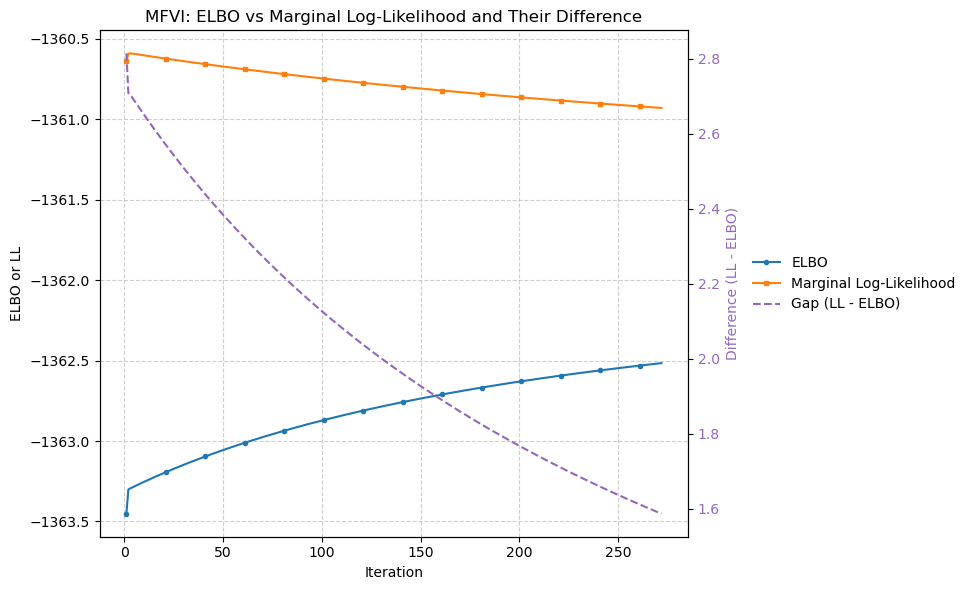

In [111]:
plot_elbo_vs_ll(history_mfvi)

## 3.7 Comparison between MFVI and EM: Posterior Mean and Variance of $ \boldsymbol{\beta} $

### 3.7.1 EM algorithm

In the **EM algorithm** for the linear mixed model:

$$
y = Z\omega + X\beta + \varepsilon, \quad 
\beta \sim \mathcal{N}(0, \sigma_\beta^2 I_p), \quad 
\varepsilon \sim \mathcal{N}(0, \sigma_e^2 I_n),
$$

the E-step computes the **posterior of** $ \beta $ given current parameters $ \Theta^{(t)} = (\omega, \sigma_e^2, \sigma_\beta^2) $:

$$
p(\beta \mid y, \Theta^{(t)}) 
= \mathcal{N}\!\left(m_{\text{EM}}, S_{\text{EM}}\right),
$$

where

$$
S_{\text{EM}} = 
\left(\frac{X^\top X}{\sigma_e^2} + \frac{I_p}{\sigma_\beta^2}\right)^{-1}, 
\qquad
m_{\text{EM}} = 
S_{\text{EM}}\frac{X^\top (y - Z\omega)}{\sigma_e^2}.
$$

Hence, the EM algorithm keeps the **exact Gaussian posterior** of $ \beta $, 
which is *fully coupled* through $ X^\top X $ — meaning that the posterior covariance 
captures the correlations between all components of $ \beta $.


### 3.7.2 Mean-Field Variational Inference (MFVI)

In **MFVI**, we use a *factorized approximation*:

$$
q(\beta) = \prod_{j=1}^p q_j(\beta_j),
$$
and assume each factor $ q_j(\beta_j) $ is Gaussian:
$$
q_j(\beta_j) = \mathcal{N}(m_j, s_j).
$$

The optimal mean-field parameters are updated coordinate-wise as:

$$
s_j^{\text{MFVI}} = 
\left( \frac{\|x_j\|^2}{\sigma_e^2} + \frac{1}{\sigma_\beta^2} \right)^{-1},
\qquad
m_j^{\text{MFVI}} = 
s_j^{\text{MFVI}} \frac{x_j^\top (y - Z\omega - \sum_{k \ne j} x_k m_k)}{\sigma_e^2}.
$$

Thus, the **posterior mean vector** under MFVI is:
$$
m_{\text{MFVI}} = (m_1, \ldots, m_p)^\top,
$$
and the **posterior variance (diagonal)** is:
$$
S_{\text{MFVI}} = \mathrm{diag}(s_1, \ldots, s_p).
$$


### 3.7.3 Comparison and Discussion

**Form**  
- EM: Multivariate Gaussian  
- MFVI: Product of independent univariate Gaussians

**Covariance**  
- EM: $ S_{\mathrm{EM}}=\big(\tfrac{X^\top X}{\sigma_e^2}+\tfrac{I}{\sigma_\beta^2}\big)^{-1} $  
- MFVI: $ S_{\mathrm{MFVI}}=\mathrm{diag}(s_1,\dots,s_p) $

**Correlation**  
- EM: Includes off-diagonal correlations  
- MFVI: Ignores correlations (independence)

**Mean**  
- EM: $ m_{\mathrm{EM}}=S_{\mathrm{EM}}\tfrac{X^\top (y-Z\omega)}{\sigma_e^2} $  
- MFVI: Coordinate-wise; depends on residuals


In [123]:
import numpy as np
import matplotlib.pyplot as plt

def compare_em_mfvi_posterior(em_mean, mfvi_mean, em_cov, mfvi_var, markevery=50):
    # Align dimensions
    em_var = np.clip(np.diag(em_cov), a_min=0.0, a_max=None)  # get diagonal and prevent negatives
    mfvi_var = np.clip(mfvi_var, a_min=0.0, a_max=None)

    # Numerical metrics 
    mean_diff = mfvi_mean - em_mean
    var_diff = mfvi_var - em_var
    eps = 1e-12

    metrics = {
        "mean_rmse": float(np.sqrt(np.mean(mean_diff**2))),
        "mean_mae": float(np.mean(np.abs(mean_diff))),
        "mean_corr": float(np.corrcoef(em_mean, mfvi_mean)[0,1]),

        "var_rmse": float(np.sqrt(np.mean(var_diff**2))),
        "var_mae": float(np.mean(np.abs(var_diff))),
        "var_ratio_median": float(np.median((mfvi_var+eps)/(em_var+eps))),
        "var_ratio_mean": float(np.mean((mfvi_var+eps)/(em_var+eps))),
    }

    print("=== EM vs MFVI Posterior Comparison ===")
    for k,v in metrics.items():
        print(f"{k:>18s}: {v:.6g}")

    p = em_mean.shape[0]
    iters = np.arange(p)

    # plot 1: Mean scatter (with y=x reference line)
    plt.figure(figsize=(6.2,5.5))
    plt.scatter(em_mean, mfvi_mean, s=8, alpha=0.5)
    lims = [min(em_mean.min(), mfvi_mean.min()), max(em_mean.max(), mfvi_mean.max())]
    plt.plot(lims, lims, linestyle="--")
    plt.xlabel("EM posterior mean")
    plt.ylabel("MFVI posterior mean")
    plt.title(f"Posterior Means (corr={metrics['mean_corr']:.3f}, RMSE={metrics['mean_rmse']:.3g})")
    plt.tight_layout()
    plt.show()

    # plot 2: Variance scatter (log-log with y=x reference line)
    plt.figure(figsize=(6.2,5.5))
    plt.scatter(np.log10(em_var+eps), np.log10(mfvi_var+eps), s=8, alpha=0.5)
    vmin = min(np.log10(em_var+eps).min(), np.log10(mfvi_var+eps).min())
    vmax = max(np.log10(em_var+eps).max(), np.log10(mfvi_var+eps).max())
    plt.plot([vmin, vmax], [vmin, vmax], linestyle="--")
    plt.xlabel("log10(EM variance)")
    plt.ylabel("log10(MFVI variance)")
    plt.title(f"Posterior Variances (ratio median={metrics['var_ratio_median']:.3g})")
    plt.tight_layout()
    plt.show()

    # plot 3: Variance ratio histogram (MFVI/EM)
    var_ratio = (mfvi_var+eps)/(em_var+eps)
    plt.figure(figsize=(6.6,4.2))
    plt.hist(var_ratio, bins=50)
    plt.xlabel("Variance ratio  (MFVI / EM)")
    plt.ylabel("Count")
    plt.title("Variance Ratio Distribution")
    plt.tight_layout()
    plt.show()



In [121]:
em_mean = beta_em["mean"]
mfvi_mean = qbeta_mfvi["mean"]

em_cov = beta_em["cov"]
mfvi_var = qbeta_mfvi["var_diag"]

=== EM vs MFVI Posterior Comparison ===
         mean_rmse: 0.00899415
          mean_mae: 0.00712939
         mean_corr: 0.999957
          var_rmse: 0.0198747
           var_mae: 0.0198747
  var_ratio_median: 0.772451
    var_ratio_mean: 0.772451


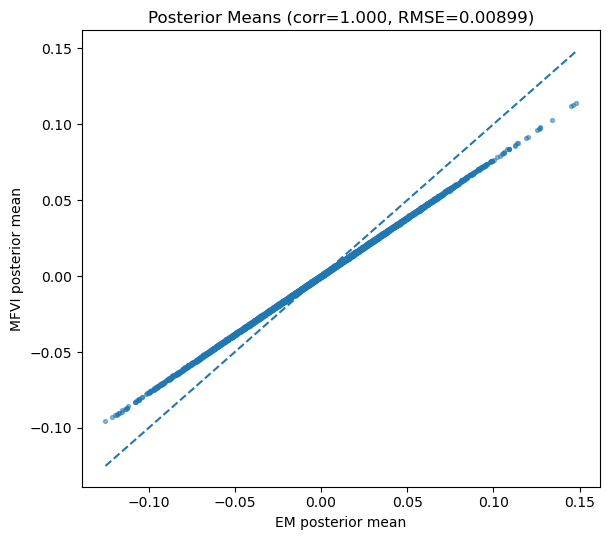

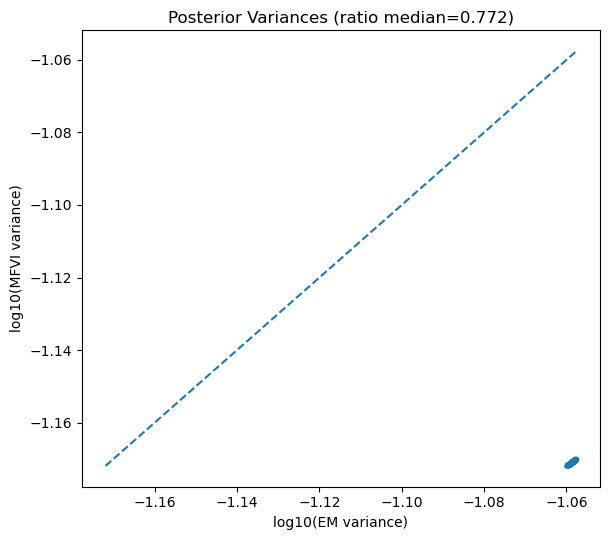

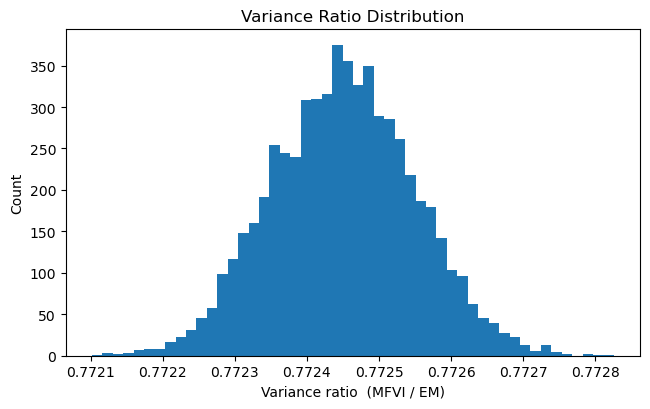

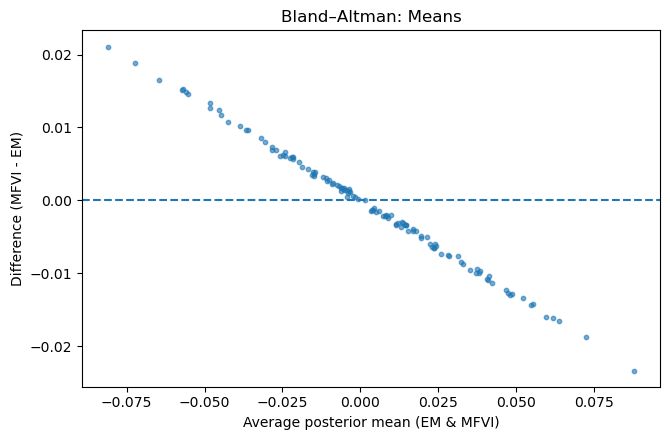

In [122]:
compare_em_mfvi_posterior(em_mean, mfvi_mean, em_cov, mfvi_var, markevery=50)